# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [7]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


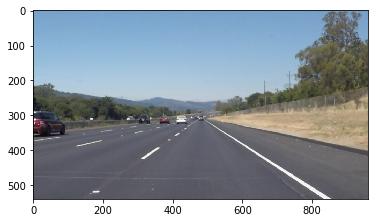

In [8]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [14]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=7):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    y_top = int(img.shape[0]/2+30) #upper y coordinate
    y_bottom = int(img.shape[0]) # lower y coordinate
    
    left_lane_x = []
    left_lane_y = []
    right_lane_x = []
    right_lane_y = []
    for line in lines:
        for x1,y1,x2,y2 in line:
            
            #if ((y2-y1)/(x2-x1))<max_pos_slope & ((y2-y1)/(x2-x1))>max_neg_slope :
            if ((y2-y1)/(x2-x1))>0.4 : # RHS lane # 22.5 degree cutoff
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                right_lane_x.append(x1)
                right_lane_y.append(y1)
                right_lane_x.append(x2)
                right_lane_y.append(y2)
            if ((y2-y1)/(x2-x1))<-0.4 :  # LHS lane  # 22.5 degree cutoff
                #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
                left_lane_x.append(x1)
                left_lane_y.append(y1)
                left_lane_x.append(x2)
                left_lane_y.append(y2)
                
    poly_left_lane = np.poly1d(np.polyfit(left_lane_y,left_lane_x,deg=1))
    left_x_bottom = int(poly_left_lane(y_bottom))
    left_x_top = int(poly_left_lane(y_top))
    poly_right_lane = np.poly1d(np.polyfit(right_lane_y,right_lane_x,deg=1))
    right_x_bottom = int(poly_right_lane(y_bottom))
    right_x_top = int(poly_right_lane(y_top))
                
    cv2.line(img, (right_x_bottom, y_bottom), (right_x_top, y_top), color, thickness)
    cv2.line(img, (left_x_bottom, y_bottom), (left_x_top, y_top), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    #hough_lines.liness = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    print((line_img.shape))
    print(type(lines))
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [15]:
import os
(os.listdir("test_images/"))

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [16]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.


## GRAYSCALE CONVERSION AND GAUSSIAN BLUR

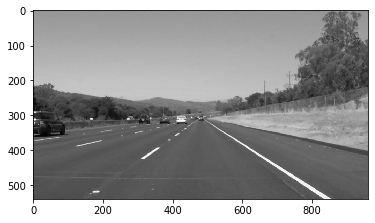

In [29]:
imshape = image.shape
image = mpimg.imread('test_images/solidWhiteRight.jpg')
gray=grayscale(image)

plt.imshow(gray, cmap='gray')


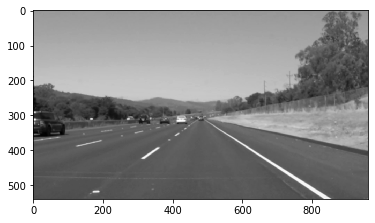

In [30]:
blur_gray=gaussian_blur(gray,5)
plt.imshow(blur_gray, cmap='gray')

## CANNY EDGE

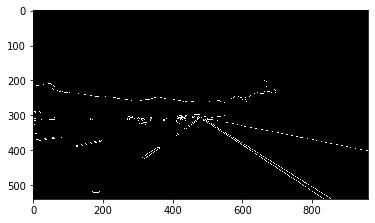

In [31]:
canny_img=canny(blur_gray, 10, 250)
plt.imshow(canny_img, cmap='gray')

## ROI

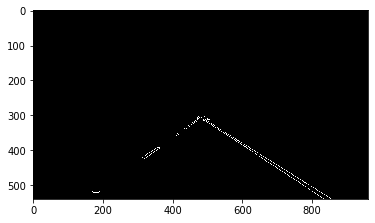

In [32]:
ysize = canny_img.shape[0]
xsize = canny_img.shape[1]

vertices = np.array([[(40,imshape[0]),(imshape[1]/2-5, imshape[0]/2+30), (imshape[1]/2+5, imshape[0]/2+30), (imshape[1]-40,imshape[0])]], dtype=np.int32)
masked_image=region_of_interest(canny_img,vertices)
plt.imshow(masked_image,cmap='gray')

## HOUGH TRANSFORM

(540, 960, 3)
<class 'numpy.ndarray'>


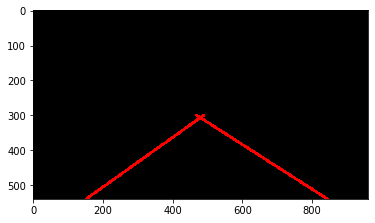

In [33]:
hough_img=hough_lines(masked_image,2,np.pi/180,15,20,20)
plt.imshow(hough_img,cmap='gray')

# EXTRAPOLATED LANES ON INITIAL IMAGE

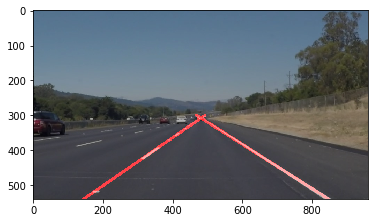

In [22]:
final_img=weighted_img(hough_img,image,0.7,1)
plt.imshow(final_img)

### Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [23]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [41]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    imshape = image.shape
    gray=grayscale(image)
    blur_gray=gaussian_blur(gray,5)
    canny_img=canny(blur_gray, 10, 250)
    ysize = canny_img.shape[0]
    xsize = canny_img.shape[1]

    vertices = np.array([[(40,imshape[0]),(imshape[1]/2-5, imshape[0]/2+30), (imshape[1]/2+5, imshape[0]/2+30), (imshape[1]-40,imshape[0])]], dtype=np.int32)
    masked_image=region_of_interest(canny_img,vertices)
    hough_img=hough_lines(masked_image,2,np.pi/180,15,7,20)
    final_img=weighted_img(hough_img,image,0.7,1)
    result=final_img



    return result

Let's try the one with the solid white lane on the right first ...

In [42]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(540, 960, 3)
<class 'numpy.ndarray'>


Moviepy - Building video test_videos_output/solidWhiteRight.mp4.


t:  45%|█████████████████████████████▉                                     | 112/251 [04:19<00:13, 10.19it/s, now=None]
                                                                                                                       


Moviepy - Writing video test_videos_output/solidWhiteRight.mp4



t:  45%|█████████████████████████████▉                                     | 112/251 [00:53<00:14,  9.92it/s, now=None]

t:   0%|                                                                             | 0/221 [00:00<?, ?it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>




t:   1%|▌                                                                    | 2/221 [00:00<00:15, 14.28it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   2%|█▌                                                                   | 5/221 [00:00<00:12, 16.74it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   4%|██▍                                                                  | 8/221 [00:00<00:11, 19.20it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   5%|███▍                                                                | 11/221 [00:00<00:09, 21.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   6%|████▎                                                               | 14/221 [00:00<00:10, 20.25it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   7%|████▉                                                               | 16/221 [00:00<00:10, 19.47it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   9%|█████▊                                                              | 19/221 [00:00<00:09, 21.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  10%|██████▊                                                             | 22/221 [00:00<00:09, 21.60it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  12%|████████                                                            | 26/221 [00:01<00:07, 24.43it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  14%|█████████▏                                                          | 30/221 [00:01<00:07, 26.22it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  15%|██████████▏                                                         | 33/221 [00:01<00:07, 23.96it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  16%|███████████                                                         | 36/221 [00:01<00:09, 20.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  18%|████████████                                                        | 39/221 [00:01<00:12, 14.27it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  19%|████████████▌                                                       | 41/221 [00:02<00:11, 15.31it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  20%|█████████████▌                                                      | 44/221 [00:02<00:09, 17.91it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  22%|██████████████▊                                                     | 48/221 [00:02<00:10, 16.00it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  23%|███████████████▋                                                    | 51/221 [00:02<00:09, 18.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  24%|████████████████▌                                                   | 54/221 [00:02<00:12, 13.47it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  26%|█████████████████▌                                                  | 57/221 [00:03<00:10, 15.75it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  27%|██████████████████▍                                                 | 60/221 [00:03<00:10, 15.18it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  28%|███████████████████                                                 | 62/221 [00:03<00:10, 15.28it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  29%|████████████████████                                                | 65/221 [00:03<00:09, 16.30it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  30%|████████████████████▌                                               | 67/221 [00:03<00:12, 12.43it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  32%|█████████████████████▌                                              | 70/221 [00:03<00:10, 14.20it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▏                                             | 72/221 [00:04<00:11, 12.52it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▊                                             | 74/221 [00:04<00:17,  8.58it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  34%|███████████████████████▍                                            | 76/221 [00:04<00:14, 10.29it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  35%|████████████████████████                                            | 78/221 [00:04<00:13, 10.63it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  36%|████████████████████████▌                                           | 80/221 [00:04<00:11, 12.22it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  37%|█████████████████████████▏                                          | 82/221 [00:05<00:11, 12.54it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  38%|██████████████████████████▏                                         | 85/221 [00:05<00:09, 14.74it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  39%|██████████████████████████▊                                         | 87/221 [00:05<00:09, 14.75it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▋                                        | 90/221 [00:05<00:08, 15.83it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  42%|████████████████████████████▌                                       | 93/221 [00:05<00:07, 18.13it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  43%|█████████████████████████████▌                                      | 96/221 [00:05<00:07, 17.77it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  44%|██████████████████████████████▏                                     | 98/221 [00:05<00:07, 17.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  45%|██████████████████████████████▎                                    | 100/221 [00:05<00:06, 18.11it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  46%|██████████████████████████████▉                                    | 102/221 [00:06<00:07, 16.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  48%|███████████████████████████████▊                                   | 105/221 [00:06<00:06, 19.12it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  49%|████████████████████████████████▋                                  | 108/221 [00:06<00:06, 17.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  50%|█████████████████████████████████▎                                 | 110/221 [00:06<00:06, 16.41it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  51%|██████████████████████████████████▎                                | 113/221 [00:06<00:06, 17.99it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  52%|██████████████████████████████████▊                                | 115/221 [00:06<00:05, 17.90it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  53%|███████████████████████████████████▍                               | 117/221 [00:06<00:06, 17.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  54%|████████████████████████████████████                               | 119/221 [00:07<00:05, 17.40it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  55%|████████████████████████████████████▉                              | 122/221 [00:07<00:05, 18.14it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  57%|█████████████████████████████████████▉                             | 125/221 [00:07<00:04, 19.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  58%|██████████████████████████████████████▊                            | 128/221 [00:07<00:05, 17.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  59%|███████████████████████████████████████▍                           | 130/221 [00:07<00:05, 15.32it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  60%|████████████████████████████████████████                           | 132/221 [00:07<00:05, 14.85it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  61%|████████████████████████████████████████▌                          | 134/221 [00:08<00:06, 13.77it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  62%|█████████████████████████████████████████▌                         | 137/221 [00:08<00:05, 15.72it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  63%|██████████████████████████████████████████▍                        | 140/221 [00:08<00:04, 17.21it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  64%|███████████████████████████████████████████                        | 142/221 [00:08<00:04, 15.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  66%|███████████████████████████████████████████▉                       | 145/221 [00:08<00:04, 18.03it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  67%|████████████████████████████████████████████▌                      | 147/221 [00:08<00:03, 18.56it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  68%|█████████████████████████████████████████████▍                     | 150/221 [00:08<00:05, 14.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  69%|██████████████████████████████████████████████                     | 152/221 [00:09<00:04, 15.03it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  70%|██████████████████████████████████████████████▋                    | 154/221 [00:09<00:04, 15.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  71%|███████████████████████████████████████████████▎                   | 156/221 [00:09<00:04, 13.87it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  71%|███████████████████████████████████████████████▉                   | 158/221 [00:09<00:04, 13.27it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  73%|█████████████████████████████████████████████████                  | 162/221 [00:09<00:03, 14.92it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  75%|██████████████████████████████████████████████████                 | 165/221 [00:09<00:03, 16.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  76%|██████████████████████████████████████████████████▋                | 167/221 [00:10<00:03, 15.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  77%|███████████████████████████████████████████████████▌               | 170/221 [00:10<00:03, 16.17it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  78%|████████████████████████████████████████████████████▏              | 172/221 [00:10<00:03, 16.00it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  79%|████████████████████████████████████████████████████▊              | 174/221 [00:10<00:03, 15.32it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  80%|█████████████████████████████████████████████████████▎             | 176/221 [00:10<00:02, 16.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  81%|█████████████████████████████████████████████████████▉             | 178/221 [00:10<00:02, 15.67it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  82%|██████████████████████████████████████████████████████▊            | 181/221 [00:10<00:02, 17.87it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  83%|███████████████████████████████████████████████████████▍           | 183/221 [00:10<00:02, 15.93it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  84%|████████████████████████████████████████████████████████▍          | 186/221 [00:11<00:02, 15.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  86%|█████████████████████████████████████████████████████████▎         | 189/221 [00:11<00:01, 16.49it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  87%|██████████████████████████████████████████████████████████▏        | 192/221 [00:11<00:01, 17.35it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  88%|██████████████████████████████████████████████████████████▊        | 194/221 [00:11<00:01, 17.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  89%|███████████████████████████████████████████████████████████▋       | 197/221 [00:11<00:01, 19.26it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  90%|████████████████████████████████████████████████████████████▋      | 200/221 [00:11<00:01, 18.14it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  91%|█████████████████████████████████████████████████████████████▏     | 202/221 [00:12<00:01, 18.05it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  93%|██████████████████████████████████████████████████████████████▏    | 205/221 [00:12<00:00, 18.31it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  94%|██████████████████████████████████████████████████████████████▊    | 207/221 [00:12<00:00, 15.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  95%|███████████████████████████████████████████████████████████████▋   | 210/221 [00:12<00:00, 16.36it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  96%|████████████████████████████████████████████████████████████████▌  | 213/221 [00:12<00:00, 16.39it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  98%|█████████████████████████████████████████████████████████████████▍ | 216/221 [00:12<00:00, 18.26it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  99%|██████████████████████████████████████████████████████████████████▍| 219/221 [00:13<00:00, 16.79it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>


Moviepy - Done !


t:  45%|█████████████████████████████▉                                     | 112/251 [04:36<00:13, 10.19it/s, now=None]
                                                                                                                       


Moviepy - video ready test_videos_output/solidWhiteRight.mp4


t:  45%|█████████████████████████████▉                                     | 112/251 [01:11<00:14,  9.92it/s, now=None]

Wall time: 17.2 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [43]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [44]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
<class 'numpy.ndarray'>


Moviepy - Building video test_videos_output/solidYellowLeft.mp4.


t:  45%|█████████████████████████████▉                                     | 112/251 [04:44<00:13, 10.19it/s, now=None]
                                                                                                                       


Moviepy - Writing video test_videos_output/solidYellowLeft.mp4



t:  45%|█████████████████████████████▉                                     | 112/251 [01:19<00:14,  9.92it/s, now=None]

t:   0%|                                                                             | 0/681 [00:00<?, ?it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>




t:   0%|▏                                                                    | 2/681 [00:00<00:38, 17.60it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   1%|▌                                                                    | 5/681 [00:00<00:33, 19.98it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   1%|▉                                                                    | 9/681 [00:00<00:29, 22.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   2%|█▎                                                                  | 13/681 [00:00<00:26, 25.49it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   2%|█▋                                                                  | 17/681 [00:00<00:24, 27.42it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   3%|██                                                                  | 21/681 [00:00<00:22, 29.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   4%|██▍                                                                 | 25/681 [00:00<00:21, 30.23it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   4%|██▉                                                                 | 29/681 [00:00<00:21, 30.88it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   5%|███▎                                                                | 33/681 [00:01<00:19, 32.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   5%|███▋                                                                | 37/681 [00:01<00:19, 33.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   6%|████                                                                | 41/681 [00:01<00:19, 33.27it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   7%|████▍                                                               | 45/681 [00:01<00:19, 33.12it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   7%|████▉                                                               | 49/681 [00:01<00:28, 22.27it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   8%|█████▏                                                              | 52/681 [00:01<00:26, 24.12it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   8%|█████▍                                                              | 55/681 [00:01<00:28, 21.62it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   9%|█████▊                                                              | 58/681 [00:02<00:29, 20.82it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   9%|██████                                                              | 61/681 [00:02<00:27, 22.50it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:   9%|██████▍                                                             | 64/681 [00:02<00:32, 19.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  10%|██████▋                                                             | 67/681 [00:02<00:31, 19.71it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  10%|██████▉                                                             | 70/681 [00:02<00:33, 18.29it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  11%|███████▎                                                            | 73/681 [00:02<00:30, 19.70it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  11%|███████▌                                                            | 76/681 [00:03<00:31, 19.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  11%|███████▊                                                            | 78/681 [00:03<00:33, 18.11it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  12%|████████                                                            | 81/681 [00:03<00:29, 20.23it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  12%|████████▍                                                           | 84/681 [00:03<00:32, 18.61it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  13%|████████▋                                                           | 87/681 [00:03<00:29, 19.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  13%|████████▉                                                           | 90/681 [00:03<00:35, 16.86it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  14%|█████████▎                                                          | 93/681 [00:03<00:30, 19.06it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  14%|█████████▌                                                          | 96/681 [00:04<00:29, 19.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  15%|█████████▉                                                          | 99/681 [00:04<00:28, 20.49it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  15%|██████████                                                         | 102/681 [00:04<00:27, 21.40it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  16%|██████████▍                                                        | 106/681 [00:04<00:27, 20.88it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  16%|██████████▋                                                        | 109/681 [00:04<00:24, 22.96it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  16%|███████████                                                        | 112/681 [00:04<00:24, 23.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  17%|███████████▎                                                       | 115/681 [00:05<00:30, 18.82it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  17%|███████████▌                                                       | 118/681 [00:05<00:28, 19.50it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  18%|███████████▉                                                       | 121/681 [00:05<00:29, 19.04it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  18%|████████████▏                                                      | 124/681 [00:05<00:28, 19.23it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  19%|████████████▍                                                      | 126/681 [00:05<00:31, 17.62it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  19%|████████████▋                                                      | 129/681 [00:05<00:28, 19.04it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  19%|████████████▉                                                      | 132/681 [00:05<00:27, 20.15it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  20%|█████████████▎                                                     | 135/681 [00:06<00:29, 18.31it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  20%|█████████████▌                                                     | 138/681 [00:06<00:27, 19.83it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  21%|█████████████▊                                                     | 141/681 [00:06<00:25, 21.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  21%|██████████████▏                                                    | 144/681 [00:06<00:30, 17.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  22%|██████████████▍                                                    | 147/681 [00:06<00:27, 19.09it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  22%|██████████████▊                                                    | 150/681 [00:06<00:33, 15.77it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  22%|███████████████                                                    | 153/681 [00:07<00:30, 17.32it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  23%|███████████████▏                                                   | 155/681 [00:07<00:30, 17.45it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  23%|███████████████▌                                                   | 158/681 [00:07<00:31, 16.72it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  24%|███████████████▊                                                   | 161/681 [00:07<00:28, 18.02it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  24%|████████████████▏                                                  | 164/681 [00:07<00:26, 19.66it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  25%|████████████████▍                                                  | 167/681 [00:07<00:28, 17.79it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  25%|████████████████▋                                                  | 170/681 [00:07<00:26, 19.36it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  25%|█████████████████                                                  | 173/681 [00:08<00:26, 19.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  26%|█████████████████▎                                                 | 176/681 [00:08<00:27, 18.45it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  26%|█████████████████▌                                                 | 178/681 [00:08<00:27, 18.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  27%|█████████████████▊                                                 | 181/681 [00:08<00:24, 20.39it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  27%|██████████████████                                                 | 184/681 [00:08<00:28, 17.52it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  27%|██████████████████▍                                                | 187/681 [00:08<00:24, 19.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  28%|██████████████████▋                                                | 190/681 [00:09<00:30, 16.19it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  28%|██████████████████▉                                                | 193/681 [00:09<00:26, 18.12it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  29%|███████████████████▎                                               | 196/681 [00:09<00:26, 17.99it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  29%|███████████████████▍                                               | 198/681 [00:09<00:29, 16.44it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  29%|███████████████████▋                                               | 200/681 [00:09<00:27, 17.33it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  30%|███████████████████▊                                               | 202/681 [00:09<00:28, 16.57it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  30%|████████████████████▏                                              | 205/681 [00:09<00:26, 18.06it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  30%|████████████████████▎                                              | 207/681 [00:10<00:29, 15.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  31%|████████████████████▋                                              | 210/681 [00:10<00:29, 15.98it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  31%|████████████████████▉                                              | 213/681 [00:10<00:27, 16.83it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  32%|█████████████████████▏                                             | 215/681 [00:10<00:30, 15.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  32%|█████████████████████▎                                             | 217/681 [00:10<00:28, 16.25it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  32%|█████████████████████▌                                             | 219/681 [00:10<00:31, 14.86it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  33%|█████████████████████▊                                             | 222/681 [00:11<00:28, 16.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▏                                            | 225/681 [00:11<00:25, 17.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▎                                            | 227/681 [00:11<00:27, 16.50it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  34%|██████████████████████▋                                            | 230/681 [00:11<00:26, 17.20it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  34%|██████████████████████▊                                            | 232/681 [00:11<00:25, 17.93it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  35%|███████████████████████                                            | 235/681 [00:11<00:23, 18.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  35%|███████████████████████▍                                           | 238/681 [00:11<00:25, 17.50it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  35%|███████████████████████▋                                           | 241/681 [00:12<00:23, 18.91it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  36%|████████████████████████                                           | 244/681 [00:12<00:21, 20.55it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  36%|████████████████████████▎                                          | 247/681 [00:12<00:28, 15.44it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  37%|████████████████████████▌                                          | 250/681 [00:12<00:24, 17.89it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  37%|████████████████████████▉                                          | 253/681 [00:12<00:23, 18.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  38%|█████████████████████████▏                                         | 256/681 [00:12<00:24, 17.00it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  38%|█████████████████████████▌                                         | 260/681 [00:13<00:22, 19.12it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  39%|█████████████████████████▉                                         | 263/681 [00:13<00:24, 16.86it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  39%|██████████████████████████▏                                        | 266/681 [00:13<00:23, 17.57it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  40%|██████████████████████████▍                                        | 269/681 [00:13<00:21, 19.07it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  40%|██████████████████████████▊                                        | 272/681 [00:13<00:25, 16.28it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  40%|██████████████████████████▉                                        | 274/681 [00:13<00:24, 16.73it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▏                                       | 276/681 [00:14<00:23, 17.53it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▎                                       | 278/681 [00:14<00:24, 16.78it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▋                                       | 282/681 [00:14<00:21, 18.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  42%|████████████████████████████▏                                      | 286/681 [00:14<00:19, 20.33it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  42%|████████████████████████████▍                                      | 289/681 [00:14<00:19, 20.60it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  43%|████████████████████████████▋                                      | 292/681 [00:14<00:20, 19.06it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  43%|████████████████████████████▉                                      | 294/681 [00:14<00:21, 17.91it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  43%|█████████████████████████████                                      | 296/681 [00:15<00:21, 18.32it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  44%|█████████████████████████████▎                                     | 298/681 [00:15<00:26, 14.39it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  44%|█████████████████████████████▌                                     | 301/681 [00:15<00:22, 16.77it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  44%|█████████████████████████████▊                                     | 303/681 [00:15<00:21, 17.61it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  45%|██████████████████████████████                                     | 305/681 [00:15<00:26, 14.17it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  45%|██████████████████████████████▏                                    | 307/681 [00:15<00:26, 14.11it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  45%|██████████████████████████████▍                                    | 309/681 [00:15<00:24, 14.98it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  46%|██████████████████████████████▌                                    | 311/681 [00:16<00:25, 14.50it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  46%|██████████████████████████████▊                                    | 313/681 [00:16<00:27, 13.61it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  46%|███████████████████████████████                                    | 316/681 [00:16<00:25, 14.04it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  47%|███████████████████████████████▎                                   | 318/681 [00:16<00:24, 14.88it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  47%|███████████████████████████████▋                                   | 322/681 [00:16<00:20, 17.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  48%|███████████████████████████████▉                                   | 324/681 [00:16<00:20, 17.28it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  48%|████████████████████████████████▎                                  | 328/681 [00:16<00:19, 18.42it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  49%|████████████████████████████████▋                                  | 332/681 [00:17<00:16, 20.86it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  49%|█████████████████████████████████                                  | 336/681 [00:17<00:16, 20.30it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  50%|█████████████████████████████████▎                                 | 339/681 [00:17<00:15, 22.05it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  50%|█████████████████████████████████▋                                 | 342/681 [00:17<00:15, 22.25it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  51%|█████████████████████████████████▉                                 | 345/681 [00:17<00:14, 22.69it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  51%|██████████████████████████████████▏                                | 348/681 [00:18<00:22, 14.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  52%|██████████████████████████████████▌                                | 351/681 [00:18<00:19, 17.02it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  52%|██████████████████████████████████▊                                | 354/681 [00:18<00:19, 16.53it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  52%|███████████████████████████████████                                | 356/681 [00:18<00:18, 17.28it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  53%|███████████████████████████████████▎                               | 359/681 [00:18<00:16, 19.70it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  53%|███████████████████████████████████▌                               | 362/681 [00:18<00:16, 19.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  54%|███████████████████████████████████▉                               | 365/681 [00:18<00:15, 20.13it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  54%|████████████████████████████████████▏                              | 368/681 [00:19<00:17, 18.23it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  54%|████████████████████████████████████▌                              | 371/681 [00:19<00:15, 20.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  55%|████████████████████████████████████▊                              | 374/681 [00:19<00:14, 21.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  55%|█████████████████████████████████████                              | 377/681 [00:19<00:13, 22.56it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  56%|█████████████████████████████████████▍                             | 380/681 [00:19<00:13, 21.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  56%|█████████████████████████████████████▋                             | 383/681 [00:19<00:13, 21.91it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  57%|█████████████████████████████████████▉                             | 386/681 [00:19<00:12, 22.87it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  57%|██████████████████████████████████████▎                            | 389/681 [00:20<00:14, 19.67it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  58%|██████████████████████████████████████▌                            | 392/681 [00:20<00:14, 20.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  58%|██████████████████████████████████████▊                            | 395/681 [00:20<00:14, 19.36it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  58%|███████████████████████████████████████▏                           | 398/681 [00:20<00:15, 17.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  59%|███████████████████████████████████████▎                           | 400/681 [00:20<00:18, 15.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  59%|███████████████████████████████████████▋                           | 403/681 [00:20<00:15, 17.48it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  59%|███████████████████████████████████████▊                           | 405/681 [00:20<00:15, 17.39it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  60%|████████████████████████████████████████                           | 407/681 [00:21<00:16, 16.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  60%|████████████████████████████████████████▏                          | 409/681 [00:21<00:16, 16.67it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  60%|████████████████████████████████████████▌                          | 412/681 [00:21<00:14, 18.08it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  61%|████████████████████████████████████████▋                          | 414/681 [00:21<00:14, 18.58it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  61%|████████████████████████████████████████▉                          | 416/681 [00:21<00:15, 17.65it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  62%|█████████████████████████████████████████▏                         | 419/681 [00:21<00:13, 19.32it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  62%|█████████████████████████████████████████▌                         | 422/681 [00:21<00:13, 18.74it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  62%|█████████████████████████████████████████▋                         | 424/681 [00:21<00:14, 17.29it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  63%|██████████████████████████████████████████                         | 427/681 [00:22<00:13, 18.89it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  63%|██████████████████████████████████████████▎                        | 430/681 [00:22<00:13, 19.01it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  63%|██████████████████████████████████████████▌                        | 432/681 [00:22<00:14, 16.86it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  64%|██████████████████████████████████████████▊                        | 435/681 [00:22<00:13, 18.59it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  64%|██████████████████████████████████████████▉                        | 437/681 [00:22<00:14, 17.14it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  65%|███████████████████████████████████████████▎                       | 440/681 [00:22<00:14, 17.13it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  65%|███████████████████████████████████████████▌                       | 443/681 [00:22<00:12, 18.90it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  65%|███████████████████████████████████████████▊                       | 445/681 [00:23<00:12, 18.35it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  66%|████████████████████████████████████████████                       | 448/681 [00:23<00:13, 17.26it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  66%|████████████████████████████████████████████▎                      | 451/681 [00:23<00:11, 19.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  67%|████████████████████████████████████████████▋                      | 454/681 [00:23<00:12, 18.09it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  67%|████████████████████████████████████████████▊                      | 456/681 [00:23<00:14, 15.17it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  68%|█████████████████████████████████████████████▎                     | 460/681 [00:23<00:12, 17.24it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  68%|█████████████████████████████████████████████▍                     | 462/681 [00:24<00:13, 16.23it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  68%|█████████████████████████████████████████████▋                     | 464/681 [00:24<00:12, 17.07it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  69%|█████████████████████████████████████████████▉                     | 467/681 [00:24<00:10, 19.46it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  69%|██████████████████████████████████████████████▏                    | 470/681 [00:24<00:10, 20.40it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  69%|██████████████████████████████████████████████▌                    | 473/681 [00:24<00:09, 22.27it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  70%|██████████████████████████████████████████████▊                    | 476/681 [00:24<00:10, 19.55it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  70%|███████████████████████████████████████████████▏                   | 479/681 [00:24<00:09, 20.69it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  71%|███████████████████████████████████████████████▍                   | 482/681 [00:24<00:09, 21.79it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  71%|███████████████████████████████████████████████▋                   | 485/681 [00:25<00:09, 20.03it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  72%|████████████████████████████████████████████████                   | 488/681 [00:25<00:09, 20.02it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  72%|████████████████████████████████████████████████▎                  | 491/681 [00:25<00:08, 21.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  73%|████████████████████████████████████████████████▌                  | 494/681 [00:25<00:11, 16.41it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  73%|████████████████████████████████████████████████▉                  | 497/681 [00:25<00:09, 18.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  73%|█████████████████████████████████████████████████▏                 | 500/681 [00:25<00:10, 16.98it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  74%|█████████████████████████████████████████████████▍                 | 503/681 [00:26<00:09, 18.17it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  74%|█████████████████████████████████████████████████▊                 | 506/681 [00:26<00:09, 18.43it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  75%|█████████████████████████████████████████████████▉                 | 508/681 [00:26<00:09, 17.52it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  75%|██████████████████████████████████████████████████▎                | 511/681 [00:26<00:08, 19.66it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  75%|██████████████████████████████████████████████████▌                | 514/681 [00:26<00:09, 18.00it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  76%|██████████████████████████████████████████████████▊                | 516/681 [00:26<00:09, 17.75it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  76%|███████████████████████████████████████████████████                | 519/681 [00:26<00:08, 19.81it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  77%|███████████████████████████████████████████████████▎               | 522/681 [00:27<00:08, 19.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  77%|███████████████████████████████████████████████████▋               | 525/681 [00:27<00:08, 18.58it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  78%|███████████████████████████████████████████████████▉               | 528/681 [00:27<00:08, 18.71it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  78%|████████████████████████████████████████████████████▏              | 531/681 [00:27<00:07, 19.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  78%|████████████████████████████████████████████████████▌              | 534/681 [00:27<00:07, 18.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  79%|████████████████████████████████████████████████████▊              | 537/681 [00:27<00:07, 19.98it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  79%|█████████████████████████████████████████████████████▏             | 540/681 [00:28<00:07, 19.34it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  80%|█████████████████████████████████████████████████████▍             | 543/681 [00:28<00:06, 20.85it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  80%|█████████████████████████████████████████████████████▋             | 546/681 [00:28<00:07, 18.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  81%|██████████████████████████████████████████████████████             | 549/681 [00:28<00:06, 19.83it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  81%|██████████████████████████████████████████████████████▎            | 552/681 [00:28<00:06, 20.95it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  81%|██████████████████████████████████████████████████████▌            | 555/681 [00:28<00:05, 21.31it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  82%|██████████████████████████████████████████████████████▉            | 558/681 [00:28<00:06, 18.84it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  82%|███████████████████████████████████████████████████████▏           | 561/681 [00:29<00:06, 18.67it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  83%|███████████████████████████████████████████████████████▍           | 564/681 [00:29<00:06, 18.64it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  83%|███████████████████████████████████████████████████████▋           | 566/681 [00:29<00:07, 16.30it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  83%|███████████████████████████████████████████████████████▉           | 568/681 [00:29<00:07, 15.79it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  84%|████████████████████████████████████████████████████████           | 570/681 [00:29<00:08, 12.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  84%|████████████████████████████████████████████████████████▎          | 572/681 [00:29<00:07, 14.11it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  84%|████████████████████████████████████████████████████████▌          | 575/681 [00:30<00:06, 16.18it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  85%|████████████████████████████████████████████████████████▊          | 577/681 [00:30<00:09, 10.87it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  85%|█████████████████████████████████████████████████████████          | 580/681 [00:30<00:07, 12.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  86%|█████████████████████████████████████████████████████████▎         | 583/681 [00:30<00:06, 14.77it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  86%|█████████████████████████████████████████████████████████▌         | 585/681 [00:30<00:06, 14.82it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  86%|█████████████████████████████████████████████████████████▊         | 588/681 [00:30<00:05, 16.44it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  87%|██████████████████████████████████████████████████████████         | 590/681 [00:31<00:05, 16.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  87%|██████████████████████████████████████████████████████████▎        | 593/681 [00:31<00:05, 17.07it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  88%|██████████████████████████████████████████████████████████▋        | 596/681 [00:31<00:04, 18.64it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  88%|██████████████████████████████████████████████████████████▊        | 598/681 [00:31<00:04, 17.48it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  88%|███████████████████████████████████████████████████████████▏       | 601/681 [00:31<00:04, 17.80it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  89%|███████████████████████████████████████████████████████████▍       | 604/681 [00:31<00:03, 19.74it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  89%|███████████████████████████████████████████████████████████▋       | 607/681 [00:31<00:03, 19.18it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  90%|████████████████████████████████████████████████████████████       | 610/681 [00:32<00:03, 18.42it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  90%|████████████████████████████████████████████████████████████▎      | 613/681 [00:32<00:03, 18.97it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  90%|████████████████████████████████████████████████████████████▌      | 616/681 [00:32<00:03, 20.49it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  91%|████████████████████████████████████████████████████████████▉      | 619/681 [00:32<00:03, 18.78it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  91%|█████████████████████████████████████████████████████████████      | 621/681 [00:32<00:03, 18.25it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  92%|█████████████████████████████████████████████████████████████▍     | 624/681 [00:32<00:02, 19.99it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  92%|█████████████████████████████████████████████████████████████▋     | 627/681 [00:32<00:02, 18.94it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  92%|█████████████████████████████████████████████████████████████▉     | 629/681 [00:33<00:02, 19.10it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  93%|██████████████████████████████████████████████████████████████▏    | 632/681 [00:33<00:02, 19.63it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  93%|██████████████████████████████████████████████████████████████▍    | 635/681 [00:33<00:02, 18.92it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  94%|██████████████████████████████████████████████████████████████▊    | 638/681 [00:33<00:02, 19.68it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  94%|███████████████████████████████████████████████████████████████    | 641/681 [00:33<00:02, 16.94it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  95%|███████████████████████████████████████████████████████████████▎   | 644/681 [00:33<00:02, 18.49it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  95%|███████████████████████████████████████████████████████████████▋   | 647/681 [00:33<00:01, 20.54it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  95%|███████████████████████████████████████████████████████████████▉   | 650/681 [00:34<00:01, 17.78it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  96%|████████████████████████████████████████████████████████████████▎  | 654/681 [00:34<00:01, 20.65it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  96%|████████████████████████████████████████████████████████████████▋  | 657/681 [00:34<00:01, 19.74it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  97%|████████████████████████████████████████████████████████████████▉  | 660/681 [00:34<00:00, 21.52it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  97%|█████████████████████████████████████████████████████████████████▏ | 663/681 [00:34<00:00, 22.83it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  98%|█████████████████████████████████████████████████████████████████▌ | 666/681 [00:34<00:00, 19.11it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  98%|█████████████████████████████████████████████████████████████████▊ | 669/681 [00:35<00:00, 20.13it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  99%|██████████████████████████████████████████████████████████████████ | 672/681 [00:35<00:00, 21.48it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t:  99%|██████████████████████████████████████████████████████████████████▍| 675/681 [00:35<00:00, 17.54it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t: 100%|██████████████████████████████████████████████████████████████████▋| 678/681 [00:35<00:00, 19.70it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>
(540, 960, 3)
<class 'numpy.ndarray'>




t: 100%|███████████████████████████████████████████████████████████████████| 681/681 [00:35<00:00, 17.16it/s, now=None]

(540, 960, 3)
<class 'numpy.ndarray'>


Moviepy - Done !


t:  45%|█████████████████████████████▉                                     | 112/251 [05:22<00:13, 10.19it/s, now=None]
                                                                                                                       


Moviepy - video ready test_videos_output/solidYellowLeft.mp4


t:  45%|█████████████████████████████▉                                     | 112/251 [01:57<00:14,  9.92it/s, now=None]

Wall time: 38.4 s


In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [46]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280, 3)
<class 'numpy.ndarray'>


Moviepy - Building video test_videos_output/challenge.mp4.


t:  45%|█████████████████████████████▉                                     | 112/251 [05:30<00:13, 10.19it/s, now=None]
                                                                                                                       


Moviepy - Writing video test_videos_output/challenge.mp4



t:  45%|█████████████████████████████▉                                     | 112/251 [02:05<00:14,  9.92it/s, now=None]

t:   0%|                                                                             | 0/251 [00:00<?, ?it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>




t:   1%|▌                                                                    | 2/251 [00:00<00:14, 16.61it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   2%|█                                                                    | 4/251 [00:00<00:14, 16.65it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   2%|█▋                                                                   | 6/251 [00:00<00:14, 17.23it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   3%|██▏                                                                  | 8/251 [00:00<00:14, 16.84it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   4%|██▋                                                                 | 10/251 [00:00<00:13, 17.48it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   5%|███▎                                                                | 12/251 [00:00<00:13, 17.80it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   6%|███▊                                                                | 14/251 [00:00<00:12, 18.39it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   7%|████▌                                                               | 17/251 [00:00<00:12, 18.65it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   8%|█████▏                                                              | 19/251 [00:01<00:12, 18.66it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   8%|█████▋                                                              | 21/251 [00:01<00:12, 18.40it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:   9%|██████▏                                                             | 23/251 [00:01<00:12, 18.26it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  10%|██████▊                                                             | 25/251 [00:01<00:12, 18.19it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  11%|███████▎                                                            | 27/251 [00:01<00:12, 17.89it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  12%|███████▊                                                            | 29/251 [00:01<00:13, 16.28it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  12%|████████▍                                                           | 31/251 [00:01<00:14, 14.96it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  13%|████████▉                                                           | 33/251 [00:01<00:14, 15.30it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  14%|█████████▍                                                          | 35/251 [00:02<00:13, 15.95it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  15%|██████████                                                          | 37/251 [00:02<00:13, 16.19it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  16%|██████████▌                                                         | 39/251 [00:02<00:12, 16.72it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  17%|███████████▍                                                        | 42/251 [00:02<00:12, 17.26it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  18%|███████████▉                                                        | 44/251 [00:02<00:12, 16.60it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  18%|████████████▍                                                       | 46/251 [00:02<00:12, 16.67it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  19%|█████████████                                                       | 48/251 [00:03<00:22,  9.15it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  20%|█████████████▌                                                      | 50/251 [00:03<00:18, 10.82it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  21%|██████████████                                                      | 52/251 [00:03<00:16, 12.00it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  22%|██████████████▋                                                     | 54/251 [00:03<00:25,  7.71it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  22%|███████████████▏                                                    | 56/251 [00:03<00:22,  8.73it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  23%|███████████████▋                                                    | 58/251 [00:04<00:29,  6.61it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  24%|████████████████▎                                                   | 60/251 [00:04<00:24,  7.82it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  25%|████████████████▊                                                   | 62/251 [00:04<00:26,  7.10it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  25%|█████████████████▎                                                  | 64/251 [00:05<00:24,  7.69it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  26%|█████████████████▉                                                  | 66/251 [00:05<00:23,  7.85it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  27%|██████████████████▍                                                 | 68/251 [00:05<00:19,  9.24it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  28%|██████████████████▉                                                 | 70/251 [00:05<00:18,  9.68it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  29%|███████████████████▌                                                | 72/251 [00:05<00:17, 10.43it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  29%|████████████████████                                                | 74/251 [00:06<00:18,  9.63it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  30%|████████████████████▌                                               | 76/251 [00:06<00:16, 10.37it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  31%|█████████████████████▏                                              | 78/251 [00:06<00:16, 10.37it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  32%|█████████████████████▋                                              | 80/251 [00:06<00:14, 11.41it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▏                                             | 82/251 [00:06<00:17,  9.88it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  33%|██████████████████████▊                                             | 84/251 [00:06<00:14, 11.39it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  34%|███████████████████████▎                                            | 86/251 [00:07<00:15, 10.45it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  35%|███████████████████████▊                                            | 88/251 [00:07<00:13, 11.77it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  36%|████████████████████████▍                                           | 90/251 [00:07<00:16,  9.93it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  37%|████████████████████████▉                                           | 92/251 [00:07<00:14, 10.97it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  37%|█████████████████████████▍                                          | 94/251 [00:07<00:14, 10.58it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  38%|██████████████████████████                                          | 96/251 [00:08<00:13, 11.70it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  39%|██████████████████████████▌                                         | 98/251 [00:08<00:16,  9.44it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  40%|██████████████████████████▋                                        | 100/251 [00:08<00:15, 10.05it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▏                                       | 102/251 [00:08<00:13, 11.08it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  41%|███████████████████████████▊                                       | 104/251 [00:08<00:13, 11.30it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  42%|████████████████████████████▎                                      | 106/251 [00:09<00:14,  9.97it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  43%|████████████████████████████▊                                      | 108/251 [00:09<00:12, 11.16it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  44%|█████████████████████████████▎                                     | 110/251 [00:09<00:12, 11.21it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>
(720, 1280, 3)
<class 'numpy.ndarray'>




t:  45%|█████████████████████████████▉                                     | 112/251 [00:09<00:12, 11.38it/s, now=None]

(720, 1280, 3)
<class 'numpy.ndarray'>


TypeError: expected non-empty vector for x

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))



t:  45%|█████████████████████████████▉                                     | 112/251 [00:29<00:12, 11.38it/s, now=None]